In [ ]:
import os
from pathlib import Path
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanbe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
# Directories for data
data_dirs = {
    "EN": "C:/Users/tanbe/nlp_narrative_classification/data/EN/raw-documents",
    "BG": "C:/Users/tanbe/nlp_narrative_classification/data/BG/translated-documents",
    "PT": "C:/Users/tanbe/nlp_narrative_classification/data/PT/translated-documents",
    "HI": "C:/Users/tanbe/nlp_narrative_classification/data/HI/translated-documents",
}

# Function to load text files and compute basic statistics
def load_text_files(data_dir):
    lengths = []
    tokenized_texts = []
    file_count = 0  # Track the number of files processed

    for file_path in Path(data_dir).glob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
            lengths.append(len(text))
            tokens = nltk.word_tokenize(text)
            tokenized_texts.append(tokens)
            file_count += 1

    return lengths, tokenized_texts

# Function to calculate sentence lengths (number of tokens per sentence)
def get_sentence_lengths(tokenized_texts):
    sentence_lengths = []
    for tokens in tokenized_texts:
        sentences = nltk.sent_tokenize(' '.join(tokens))  # Split the text into sentences
        for sentence in sentences:
            sentence_tokens = nltk.word_tokenize(sentence)  # Tokenize the sentence
            sentence_lengths.append(len(sentence_tokens))  # Count tokens in the sentence
    return sentence_lengths

# Load data
data_stats = {}
for lang, path in data_dirs.items():
    lengths, tokenized_texts = load_text_files(path)
    sentence_lengths = get_sentence_lengths(tokenized_texts)  
    data_stats[lang] = {
        "lengths": lengths,
        "tokenized_texts": tokenized_texts,
        "vocab_size": [len(set(tokens)) for tokens in tokenized_texts],
        "sentence_lengths": sentence_lengths, 
    }

# Final validation
for lang, stats in data_stats.items():
    print(f"Language: {lang}")
    print(f"  Number of files: {len(stats['lengths'])}")
    print(f"  Average file length: {sum(stats['lengths']) / len(stats['lengths']):.2f} characters")
    print(f"  Average vocabulary size: {sum(stats['vocab_size']) / len(stats['vocab_size']):.2f} unique words")
    print(f"  Average sentence length: {sum(stats['sentence_lengths']) / len(stats['sentence_lengths']):.2f} tokens")


Language: EN
  Number of files: 200
  Average file length: 3156.74 characters
  Average vocabulary size: 282.35 unique words
  Average sentence length: 26.62 tokens
Language: BG
  Number of files: 211
  Average file length: 1928.32 characters
  Average vocabulary size: 182.68 unique words
  Average sentence length: 24.54 tokens
Language: PT
  Number of files: 200
  Average file length: 2362.39 characters
  Average vocabulary size: 215.21 unique words
  Average sentence length: 29.57 tokens
Language: HI
  Number of files: 115
  Average file length: 3677.95 characters
  Average vocabulary size: 273.60 unique words
  Average sentence length: 21.69 tokens


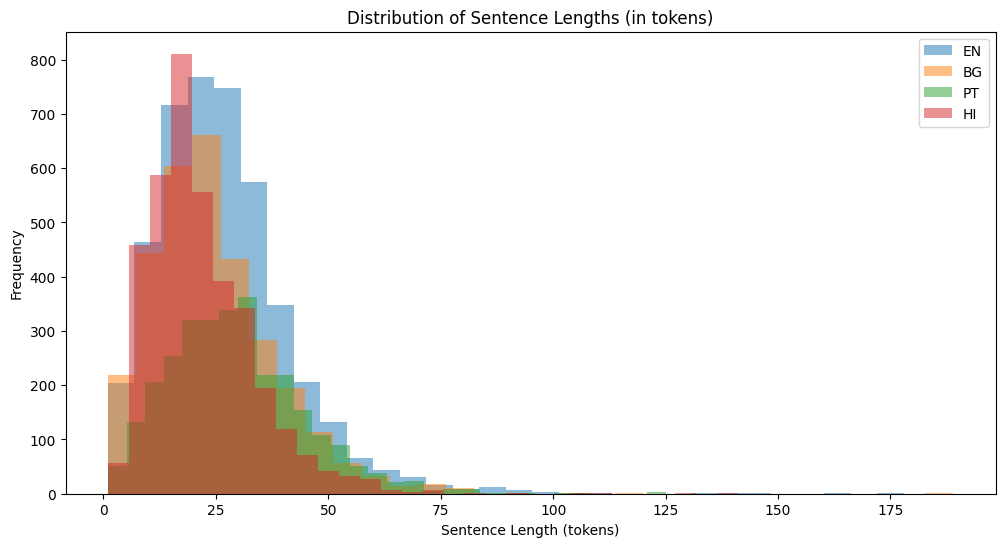

In [37]:

# Sentence length distribution (in tokens)
plt.figure(figsize=(12, 6))
for lang, stats in data_stats.items():
    plt.hist(stats["sentence_lengths"], bins=30, alpha=0.5, label=lang)
plt.title("Distribution of Sentence Lengths (in tokens)")
plt.xlabel("Sentence Length (tokens)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


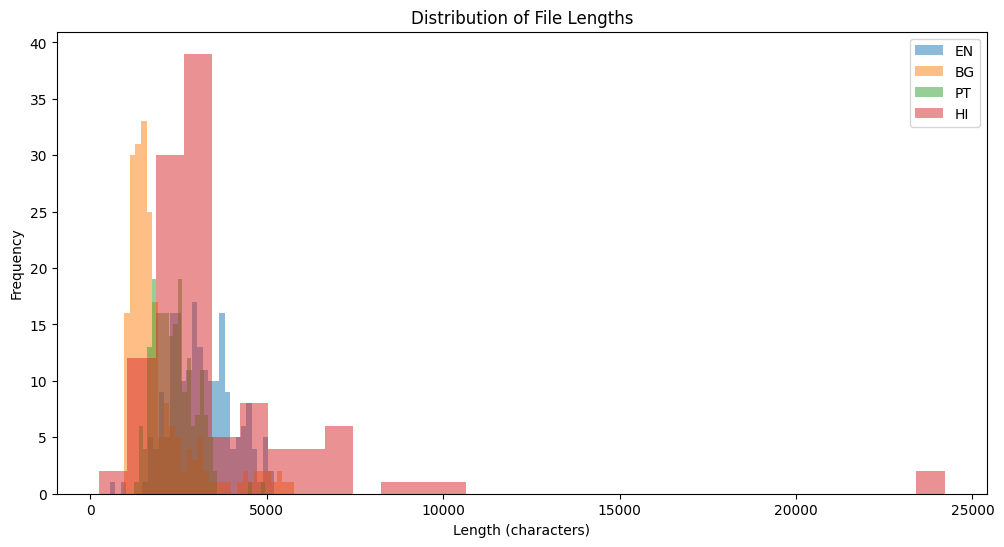

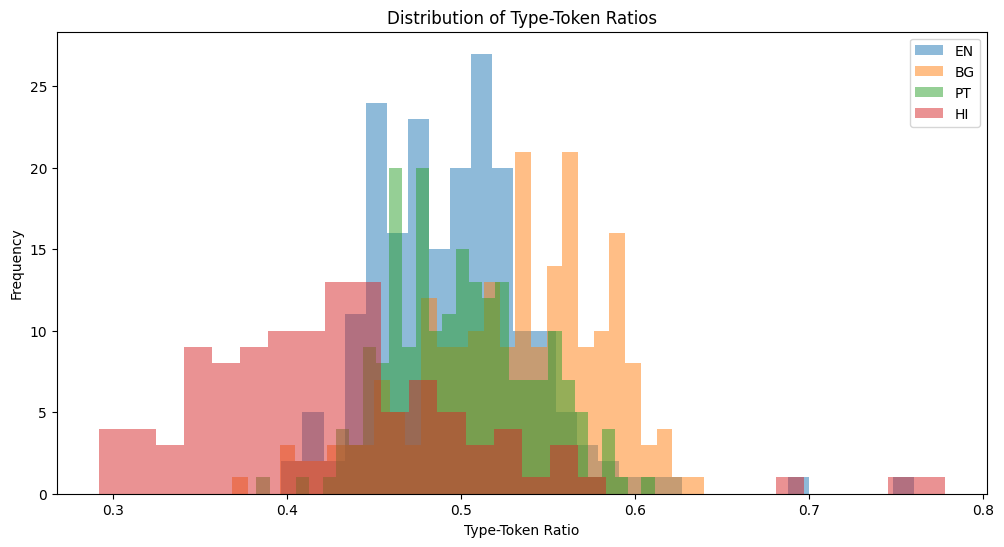

In [38]:
# Plot file lengths
plt.figure(figsize=(12, 6))
for lang, stats in data_stats.items():
    plt.hist(stats["lengths"], bins=30, alpha=0.5, label=lang)
plt.title("Distribution of File Lengths")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Vocabulary richness (Type-Token Ratio)
#Type-Token Ratio is a measure of vocabulary richness, calculated as the ratio of unique words (vocabulary size) to the total number of words (tokens) in a document
plt.figure(figsize=(12, 6))
for lang, stats in data_stats.items():
    ttr = [vocab / len(tokens) for vocab, tokens in zip(stats["vocab_size"], stats["tokenized_texts"])]
    plt.hist(ttr, bins=30, alpha=0.5, label=lang)
plt.title("Distribution of Type-Token Ratios")
plt.xlabel("Type-Token Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In [ ]:
# Word frequency distributions
def get_word_frequency(texts):
    all_tokens = [word.lower() for tokens in texts for word in tokens]
    return Counter(all_tokens)

word_freqs = {lang: get_word_frequency(stats["tokenized_texts"]) for lang, stats in data_stats.items()}

# Cosine similarity of word frequency vectors
vectorizer = CountVectorizer()
langs = list(data_dirs.keys())
corpus = [" ".join(tokens) for lang in langs for tokens in data_stats[lang]["tokenized_texts"]]
vectorized = vectorizer.fit_transform(corpus).toarray()

# Cosine similarity matrix
# computes the average word frequency vector for English, and this is compared to the frequency vectors for the other languages
cosine_sim = cosine_similarity(vectorized[:len(data_stats["EN"]["tokenized_texts"])].mean(axis=0, keepdims=True), 
                                vectorized[len(data_stats["EN"]["tokenized_texts"]):])

similarities = {langs[i]: cosine_sim[0][i - 1] for i in range(1, len(langs))}


In [41]:
# Ranking based on similarity
ranked = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

print("Ranking of Translated Datasets (Similarity to English):")
for i, (lang, score) in enumerate(ranked, 1):
    print(f"{i}. {lang}: {score:.4f}")

Ranking of Translated Datasets (Similarity to English):
1. HI: 0.8957
2. BG: 0.8238
3. PT: 0.6632
